In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as tfl

tfds.disable_progress_bar()

### 1. Load and preprocess the data

#### 1.1. Loading the dataset

In [18]:
# Loading "cats_vs_dogs" dataset - one of the Tensorflow's ready-made datasets: 
catdog_dataset, catdog_info = tfds.load(name='cats_vs_dogs:4.0.0', split='train', 
                                        shuffle_files=True, with_info=True, as_supervised=True)

In [19]:
print ('The number of examples in the dataset:', catdog_info.splits['train'].num_examples)

The number of examples in the dataset: 23262


#### 1.2. Redusing the size of the dataset (from 23262 to 600 examples)

In [20]:
# Redusing the size of the dataset (from 23262 to 600 examples) 
# in order to see how Transfer learning works for classification of a small dataset


# Shuffling the data
buffer_size = 100
shuffled_dataset = catdog_dataset.shuffle(buffer_size)

# Redusing the size of the dataset (take 600 examples)
num_dataset_samples = 500
reduced_shuffled_dataset = shuffled_dataset.take(num_dataset_samples)

#### 1.3. Dividing into train and validation datasets

In [21]:
# Choosing the size for validation set (as 20% of the dataset's size)
num_validation_samples = num_dataset_samples*0.2
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

# Dividing into train and validation datasets
validation_data = reduced_shuffled_dataset.take(num_validation_samples)
train_data = reduced_shuffled_dataset.skip(num_validation_samples)

#### 1.4. Resizing and standardizing images. Batching and prefetching the dataset.

In [32]:
IMG_SIZE = (224, 224)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)/255.0
    return image,label

# Batching and resizing dataset
BATCH_SIZE = 32
train_dataset = train_data.map(format_image).batch(BATCH_SIZE)
validation_dataset = validation_data.map(format_image).batch(BATCH_SIZE)

In [33]:
# Using prefetch() that prevents a memory bottleneck that can occur when reading from disk. 
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

#### 1.5. Checking the number of cats and dogs images in the dataset

In [34]:
# Checking the train dataset
labels = np.array([])
for _, label_batch in train_dataset:
    labels = np.concatenate((labels, label_batch))

num_images = labels.shape[0]

print(f"Train set is composed of {num_images} images: "
      f"{np.count_nonzero(labels==0)} cats and "
      f"{np.count_nonzero(labels==1)} dogs.")

# Checking the validation dataset
labels = np.array([])
for _, label_batch in validation_dataset:
    labels = np.concatenate((labels, label_batch))

num_images = labels.shape[0]

print(f"Validation set is composed of {num_images} images: "
      f"{np.count_nonzero(labels==0)} cats and "
      f"{np.count_nonzero(labels==1)} dogs.")

Train set is composed of 400 images: 206 cats and 194 dogs.
Validation set is composed of 100 images: 49 cats and 51 dogs.


### 2. Creating a transfer model (using MobileNetV2 pre-trained on ImageNet dataset)

#### 2.1. Loading a pre-trained MobileNetV2 model

In [37]:
tfds.disable_progress_bar()
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [38]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

block_4_expand_relu (ReLU)      (None, 28, 28, 192)  0           block_4_expand_BN[0][0]          
__________________________________________________________________________________________________
block_4_depthwise (DepthwiseCon (None, 28, 28, 192)  1728        block_4_expand_relu[0][0]        
__________________________________________________________________________________________________
block_4_depthwise_BN (BatchNorm (None, 28, 28, 192)  768         block_4_depthwise[0][0]          
__________________________________________________________________________________________________
block_4_depthwise_relu (ReLU)   (None, 28, 28, 192)  0           block_4_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_4_project (Conv2D)        (None, 28, 28, 32)   6144        block_4_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_4_pr

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 14, 14, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 14, 14, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 14, 14, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 14, 14, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 14, 14, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 14, 14, 576)  0           block_13_expand_BN[0][0]         
__________________________________________________________________________________________________
block_13_pad (ZeroPadding2D)    (None, 15, 15, 576)  0           block_13_expand_relu[0][0]       
__________________________________________________________________________________________________
block_13_depthwise (DepthwiseCo (None, 7, 7, 576)    5184        block_13_pad[0][0]               
__________________________________________________________________________________________________
block_13_depthwise_BN (BatchNor (None, 7, 7, 576)    2304        block_13_depthwise[0][0]         
__________

__________________________________________________________________________________________________


In [39]:
# Normilizing the input the same way it is normalized in pre-trained MobileNetV2 model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### 2.2. Creating a "Cats vs Dogs" transfer model

In [42]:
# Creating a Transfer model: taking all layers of MobileNetV2 except for the last one (1000-classes classification layer),
# freezing them and then adding new Binary classification layers.

def catsdogs_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    
    # Define pre-trained MobileNetV2 without the top layer as a base for our transfer model
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # exclude the top layer
                                                   weights='imagenet') # taking weights from ImageNet dataset
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(inputs, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(rate=0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tf.keras.layers.Dense(units=1)
    
    outputs = prediction_layer(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [44]:
tfds.disable_progress_bar()
catdog_model = catsdogs_model(IMG_SIZE)

In [45]:
catdog_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
# Compiling the model (with Adam optimizer and Binary crossentropy loss function)
base_learning_rate = 0.01
catdog_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### 2.3. Training a "Cats vs Dogs" transfer model

In [47]:
initial_epochs = 2
history = catdog_model.fit(train_dataset, 
                           validation_data=validation_dataset, 
                           epochs=initial_epochs, 
                           verbose=2)

Epoch 1/2
13/13 - 15s - loss: 0.1570 - accuracy: 0.9250 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/2
13/13 - 10s - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.0149 - val_accuracy: 0.9900


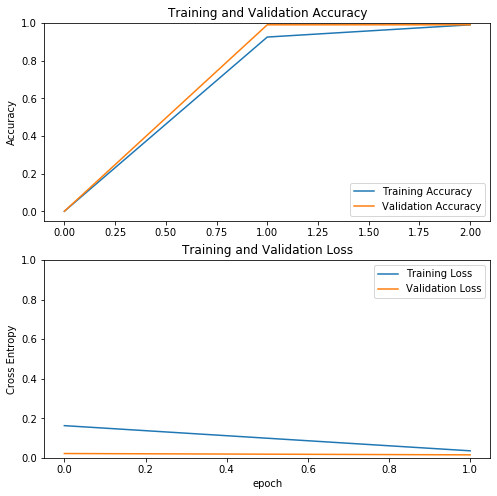

In [48]:
# Plotting the training and validation accuracy:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 3. Fine-tuning a "Cats vs Dogs" transfer model

In [49]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  157


#### 3.1. Unfreezing the base model's top layers and re-training them with a smaller learning rate

In [50]:
# Unfreezing the model layers
base_model.trainable = True

# Choosing the number of the first layer that we will begin fine-tune from
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
catdog_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1*base_learning_rate),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=['accuracy'])

#### 3.2. Fine-tuning the "Cats vs Dogs" transfer model

In [53]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = catdog_model.fit(train_dataset,
                                epochs=total_epochs,
                                initial_epoch=history.epoch[-1],
                                validation_data=validation_dataset, 
                                verbose=2)

Epoch 2/4
13/13 - 13s - loss: 0.0368 - accuracy: 0.9850 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/4
13/13 - 10s - loss: 0.0169 - accuracy: 0.9900 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 4/4
13/13 - 10s - loss: 0.0107 - accuracy: 0.9975 - val_loss: 0.0062 - val_accuracy: 1.0000


In [54]:
# Plotting the training and validation accuracy:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

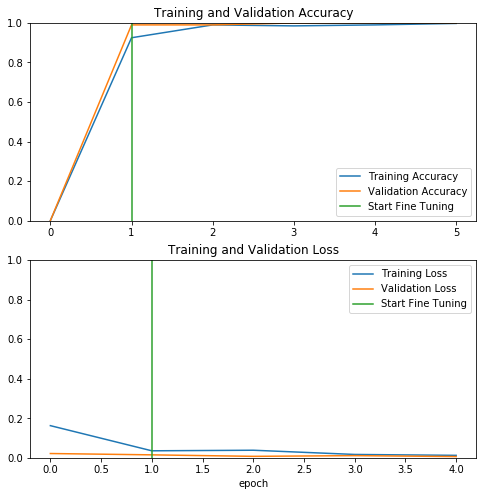

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()